In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
from lifelines.utils import concordance_index, survival_table_from_events
from lifelines import CoxPHFitter, AalenAdditiveFitter
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [2]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_cox"


for d in [EXP_PATH]:
    if not d.exists():
        d.mkdir()

In [3]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
slides = slides.loc[slides.sample_type_id == 1]
slide_level = 'level_1'
slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
slides = slides.loc[slides.days_proxy.notnull()]
slides['death'] = True
slides.loc[slides.days_to_last_follow_up.notnull(),'death'] = False    
slides['death'] = slides['death'].astype(int)
slides['sec_loc'] = (slides.section_location == 'TOP').astype(int)

features =  [    
    'age_at_diagnosis'
]

targets = [
    'days_proxy',
    'death',  
]

fit_df = slides.groupby('submitter_id').first()[features+targets].dropna()
n_patients = len(fit_df)



fit_df['age_at_diagnosis'] = (fit_df['age_at_diagnosis']+1).apply(np.log) - 6.0
    
    

#fit_df['age_at_diagnosis'] = (fit_df['age_at_diagnosis'] - 5000) / 30000

idx = np.random.permutation(fit_df.index)
split = int(0.8 * n_patients)
val_split = int(0.5 * split)

In [4]:
fit_df['age_at_diagnosis'].describe()

count    373.000000
mean       3.958913
std        0.275079
min        2.676417
25%        3.848820
50%        4.019402
75%        4.136779
max        4.377265
Name: age_at_diagnosis, dtype: float64

In [5]:
def replicate_with_jjitter(df, n=10, jitter=0.01):
    new_dfs = [df]
    for i in range(n):
        df_jitter = df.copy()
        jit_seq = 1.0 - np.random.randn(len(df_jitter)) * 0.01
        df_jitter['age_at_diagnosis'] *= jit_seq
        jit_seq = 1.0 - np.random.randn(len(df_jitter)) * 0.01
        df_jitter['days_proxy'] *= jit_seq
        new_dfs.append(df_jitter)
    return pd.concat(new_dfs)

train_df = fit_df.loc[idx[0:val_split]]
val_df = fit_df.loc[idx[val_split:split]]
test_df = fit_df.loc[idx[split:]]

        
len(train_df), len(val_df), len(test_df)

(149, 149, 75)

In [6]:
model = CoxPHFitter()
model.fit(train_df, 'days_proxy', event_col='death')

<lifelines.CoxPHFitter: fitted with 149 observations, 114 censored>

In [7]:
pred_df = train_df
y_pred = model.predict_expectation(pred_df[features]).values
concordance_index(pred_df.days_proxy, y_pred, event_observed=pred_df.death )

0.6583947266382318

In [8]:
pred_df = val_df
y_pred = model.predict_expectation(pred_df[features]).values
concordance_index(pred_df.days_proxy, y_pred, event_observed=pred_df.death )

0.5048592493297587

In [9]:
pred_df = test_df
y_pred = model.predict_expectation(pred_df[features]).values
concordance_index(pred_df.days_proxy, y_pred, event_observed=pred_df.death )

0.6330845771144279

In [10]:
mult = 300
train_df = replicate_with_jjitter(train_df, mult)
val_df = replicate_with_jjitter(val_df, mult)
test_df = replicate_with_jjitter(test_df, mult)

len(train_df), len(val_df), len(test_df)

(44849, 44849, 22575)

In [11]:
from fastai import *
from fastai.column_data import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_age"
EXP_MODEL_PATH = EXP_PATH/"models"
    
for d in [EXP_PATH, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [12]:
class SurvialDataset(Dataset):
    def __init__(self, xs, ys, is_reg=False, is_multi=False):
        self.xs = xs
        self.y = ys
        self.is_reg = is_reg
        self.is_multi = is_multi

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): 
        return [self.xs[idx]] + [self.y[idx]]

def get_data(bs):
    def make_ds(df):
        return SurvialDataset(df[features].values, df[targets].values)
    train_ds = make_ds(train_df)
    val_ds = make_ds(val_df)
    test_ds = make_ds(test_df)

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)

    mdata = ModelData.from_dls(EXP_PATH, train_dl, val_dl, test_dl=test_dl)
    return mdata

bs = 512
data = get_data(bs)

In [13]:
class ConcordanceIndex(Callback):
    def __init__(self, ):
        self.reset()

    def on_epoch_begin(self, metrics):
        self.reset()

    def on_epoch_end(self, metrics):
        #import pdb; pdb.set_trace()
        ci = concordance_index(
            self.evt_times, 
            self.preds, 
            self.evt_types
        )
        print('ci: ', ci)
        self.reset()

    def reset(self):
        self.preds = np.array([])
        self.evt_times = np.array([])
        self.evt_types = np.array([])
        self.mcount = 0
       
    def concordance_metric(self, preds, target):
        #import pdb; pdb.set_trace()
        #print(preds.sum().item())
        self.evt_times = np.concatenate([self.evt_times, np.array(target[:,0])])
        self.evt_types = np.concatenate([self.evt_types, np.array(target[:,1])])
        self.preds = np.concatenate([self.preds, np.array(preds[:,0])])
        self.mcount += 1
        return 0.0 #self.mcount  

In [33]:
def convex(x, y, sigma=1.0): 
    '''
    any convex function probably would work
    sigma here looks like a hyperparam
    '''
    #print('sigma:', sigma)
    return torch.exp(-(x-y)/sigma)

def deephit_loss(preds, evt_times, evt_types, eps=1e-2, sigma=1.0):
    #import pdb; pdb.set_trace()
    t_max = preds.shape[1]
    preds_cdf = torch.cumsum(preds, dim=1)
    
    uncensored_idx = evt_types > 0
    censored_idx = evt_types == 0
    n_unc = uncensored_idx.sum().item()
    n_cen = censored_idx.sum().item()
    
    # prob loss
    if n_unc > 0:
        l1_part1_probs = preds[uncensored_idx, evt_times[uncensored_idx]]
        l1_part_1 = torch.sum(torch.log(l1_part1_probs))
    else:
        l1_part_1 = 0.0
    
    if n_cen > 0:
        #import pdb; pdb.set_trace()
        l1_part_2 = torch.log(1 - preds_cdf[censored_idx, evt_times[censored_idx]] + eps).sum()
    else:
        l1_part_2 = 0.0
        
    l1_loss = -(l1_part_1 + l1_part_2)
    
    # pairwise concordance loss
    if True:
        preds_cdf_uncensored = preds_cdf[uncensored_idx]
        evt_times_uncensored = evt_times[uncensored_idx]

        pair_idxs = [] # (si, i, j)
        for idx_i, si in enumerate(evt_times_uncensored):
            for idx_j, sj in enumerate(evt_times_uncensored):
                if idx_i != idx_j:
                    if si < sj:
                        pair_idxs.append([si, idx_i, idx_j])

        # index to si cdf values for both paient
        pairwise_loss = 0.0
        for si, idx_i, idx_j in pair_idxs:
            Fki = preds_cdf_uncensored[idx_i, si]
            Fkj = preds_cdf_uncensored[idx_j, si]
            pairwise_loss += convex(Fki, Fkj, sigma=sigma)
    else:
        pairwise_loss = l1_loss

    return l1_loss, pairwise_loss

def custom_loss(preds, target, beta = 0.1):
    evt_times = target[:,0].long()
    evt_types = target[:,1].long()
    
    l1, l2 = deephit_loss(preds, evt_times, evt_types, eps=1e-5, sigma=1.0)
    #print("peek\n",l1.item(),l2.item())
    loss = l1 + beta * l2
    return loss

In [34]:
class SurvModel(nn.Module):
    def __init__(self, n_feat, hidden):
        super().__init__()
        self.in_layer = nn.Linear(in_features=n_feat, out_features=hidden)
        self.bn_in = nn.BatchNorm1d(hidden)
        
        self.layer_1 = nn.Linear(in_features=hidden, out_features=hidden//2)
        self.bn1 = nn.BatchNorm1d(hidden//2)

        self.out_layer = nn.Linear(in_features=hidden//2, out_features=t_max)
        self.out_activation = nn.Softmax()

    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = self.in_layer(x)
        x = self.bn_in(x)
        x = F.relu(x)
        x = F.dropout(x)

        x = self.layer_1(x) 
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x) 

        x = self.out_layer(x)
        x = self.out_activation(x)
        #x = self.bn2(x)
        #x = F.relu(x)
        #x = F.softmax(x)
        return x

t_max = int(fit_df.days_proxy.max()*1.05)

model = SurvModel(1,512)
learn = Learner.from_model_data(model, data)
learn.crit = custom_loss
learn.opt_fn = optim.Adam

cindex = ConcordanceIndex()
callbacks = [cindex]
learn.metrics = [cindex.concordance_metric]


In [37]:
#learn.lr_find()
#learn.sched.plot()

In [85]:
cindex = ConcordanceIndex()
callbacks = [cindex]
learn.metrics = [cindex.concordance_metric]

cindex.reset()
learn.fit(0.01, 
          1, cycle_len=2, 
          use_clr_beta = (40,20,0.95,0.85), 
          callbacks = callbacks)

ci:  0.5308802118624933                                       
epoch      trn_loss   val_loss   concordance_metric 
    0      1436.392884 2397.462405 0.0       
ci:  0.5452765793822884                                       
    1      1424.471334 3309.21009 0.0       


[3309.2100902886455, 0.0]

In [86]:
#learn.predict(is_test=True)

In [87]:
pred, targs = learn.predict_with_targs(is_test=True)
pred = np.argmax(pred,1)

In [88]:
pred.shape

(22575,)

In [89]:
targs.shape

(22575, 2)

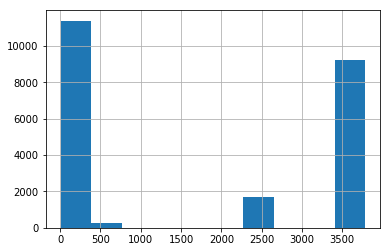

In [90]:
pd.Series(pred.flatten()).hist()

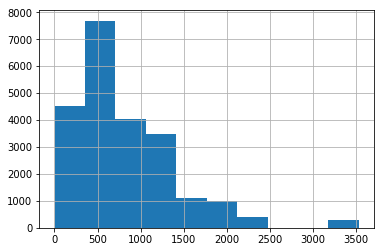

In [91]:
pd.Series(targs[:,0]).hist()

In [92]:
concordance_index(targs[:,0], pred, event_observed=targs[:,1])

0.5945560634273173

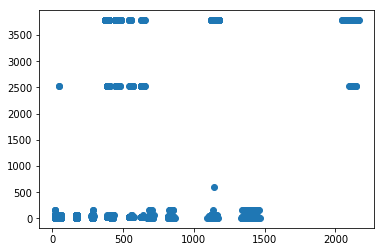

In [93]:
pred1 = pred[targs[:,1] == 1]
actual = targs[targs[:,1] == 1,0]
scatter(actual, pred1)

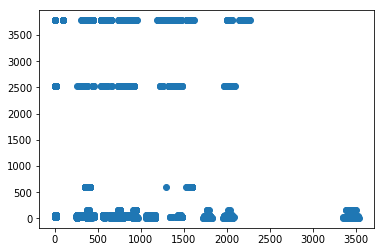

In [94]:
pred1 = pred[targs[:,1] == 0]
actual = targs[targs[:,1] == 0,0]
scatter(actual, pred1)